# Baseline solution

Goal of this notebook is to implement simple solution and get score to propose our initial hypothesys. As a baseline I will use idea of removing words that correlate with high-toxic score.  

Prerequirements to run this notebook:
* download all libraries mentioned in `requirements.txt`
* download [filtered ParaNMT-detox corpus dataset](https://github.com/skoltech-nlp/detox/releases/download/emnlp2021/filtered_paranmt.zip)
* unzip archive via graphical interface (ui.py) or just by hands to a directory `../data/raw/filtered_paranmt/filtered.tsv`

Basic information about the dataset
* `reference` (str) - First item from the pair
* `ref_tox` (float) - toxicity level of reference text
* `translation` (str) - second item from the pair - paraphrazed version of the reference
* `trn_tox` (float) - toxicity level of translation text
* `similarity` (float) - cosine similarity of the texts
* `lenght_diff` (float) - relative length difference between texts

In [1]:
import pandas as pd

df = pd.read_table('../data/raw/filtered_paranmt/filtered.tsv', index_col=0)

df.head()

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348


# Preprocessing step

I will use techniques 1.1-1.3 (from `LearningDataset` notebook) for preprocessing. Main idea is to split translation/reference to toxic/non-toxic columns (as they are mixed) and introduce some threasholds on simmilarity and toxicity.


1.1 During data preprocessing introduce new features `toxic` and `non-toxic` based on `ref_tox` and `trn_tox` scores.\
1.2 Introduce `toxisity_difference` threashold duting preprocessing.\
1.3 Tune which `simmilarity` value to consider in order to save sence of the sentences.

In [2]:
toxisity_difference = 0.75
simmilarity_rate = 0.65

In [3]:
# split words to toxic & non-toxic based on rate [1.1]
tox_queries = []
ntox_queries = []

for tox_query, ntox_query, sim, len_diff, tox, ntox in df.values:
    if tox < ntox:
        tox, ntox = ntox, tox
        tox_query, ntox_query = ntox_query, tox_query 
    
    # add threasholds on toxisity_difference [1.2] and simmilarity rate [1.3]
    if (tox - ntox) >= toxisity_difference and sim >= simmilarity_rate:
        tox_queries.append((tox_query, tox))
        ntox_queries.append((ntox_query, ntox))

print(f'Queries passed: {round(100 * len(tox_queries) / df.shape[0], 2)}%')

# convert processed data to dataframes
tox = pd.DataFrame(tox_queries, columns=['message', 'tox_score'])
non_tox = pd.DataFrame(ntox_queries, columns=['message', 'tox_score'])

tox.head()

Queries passed: 72.61%


,message,tox_score
0,"if Alkar floods her with her mental waste, it ...",0.981983
1,you're becoming disgusting.,0.999039
2,"well, we can spare your life.",0.985068
3,"monkey, you have to wake up.",0.994215
4,I have orders to kill her.,0.999348


In [4]:
from nltk.tokenize import word_tokenize

# tokenize
tox['message'] = tox.message.str.lower().apply(word_tokenize)
non_tox['message'] = non_tox.message.str.lower().apply(word_tokenize)

tox.head()

/home/cutefluffyfox/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,message,tox_score
0,"[if, alkar, floods, her, with, her, mental, wa...",0.981983
1,"[you, 're, becoming, disgusting, .]",0.999039
2,"[well, ,, we, can, spare, your, life, .]",0.985068
3,"[monkey, ,, you, have, to, wake, up, .]",0.994215
4,"[i, have, orders, to, kill, her, .]",0.999348


In [5]:
from sklearn.model_selection import train_test_split

X = tox
y = non_tox

# split data to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print('Train size:', X_train.size)
print('Test size:', X_test.size)

Train size: 755090
Test size: 83900


# Model itself 

For baseline model I suggested an idea of simple toxic-word remover. For that we already explored how to determine such words `1.4` and `1.6` (in `LearningDataset` notebook). Basically we can calculate mean and standart deviation for each sentence word appears in. With that, we can define threashold of toxicity (mean) and out certainty (std). With this idea we suppose to get all curse words and words with the only toxic meaning. For words that could be both toxic and non-toxic (e.g. kill) std ideally should be high enough, so they won't be included in the list.

In [6]:
import numpy as np


class ToxicWordRemover:
    def __init__(self, std: float = 0.1, mean: float = 0.9, n_occurences: int = 20):
        self.word_tox = dict()
        self.toxic_words = set()
        self.update_params(std=std, mean=mean, n_occurences=n_occurences, recalculate=False)
    
    def fit(self, toxic: pd.DataFrame, non_toxic: pd.DataFrame, with_scores: float = False):
        # check if scores exists, if no, add them
        if not with_scores:
            toxic['tox_score'] = 1
            non_tox['tox_score'] = 0
        
        # combine sentences
        combined = pd.concat([toxic, non_toxic])
        
        # calculate mean/std toxisity levels for each word (from most popular one)
        word_tox = dict()

        # iterate through all tokens and add their' toxisity value to dict
        for words, tox_level in combined.values:
            for word in words:
                
                if word not in word_tox:
                    word_tox[word] = []

                word_tox[word].append(tox_level)
        
        # convert all values to numpy for faster statistics
        for word in word_tox:
            word_tox[word] = np.array(word_tox[word])
        
        # save raw data for recalculation purposes
        self.word_tox = word_tox
        
        # determine toxic words and save them
        self.__determine_toxic()
        
    
    def predict(self, sentences):
        filtered = []
        
        for sentence in sentences.values:
            filtered.append([])
            for word in sentence:
                # for each word in sentence check if it's toxic
                if word not in self.toxic_words:  # ignore if it's toxic
                    filtered[-1].append(word)
        
        return filtered
    
    def update_params(self, std: float = None, mean: float = None, n_occurences: int = None, recalculate: bool = True):
        # update any parameter
        if std is not None:
            self.std = std
        if mean is not None:
            self.mean = mean
        if n_occurences is not None:
            self.n_occurences = n_occurences
        
        # update toxic words if needed
        if recalculate:
            self.__determine_toxic()
    
    def get_toxic_words(self):
        return self.toxic_words
    
    def __determine_toxic(self):
        self.toxic_words = set()
        
        # determine what words satisfy our toxicity requirements
        for word, tox_levels in self.word_tox.items():
            if (
                tox_levels.std() < self.std and 
                tox_levels.mean() > self.mean and 
                tox_levels.size >= self.n_occurences
               ):
                self.toxic_words.add(word)
    
    def __call__(self, X):
        return self.predict(X)

In [7]:
# Train model
model = ToxicWordRemover(std=0.2, mean=0.6, n_occurences=20)
model.fit(X_train, y_train, with_scores=True)

print('Found toxic words:', len(model.get_toxic_words()))

Found toxic words: 128


# Make predictions and validate them

To validate model I will use the same approach as defined in the initial paper (check `ToxicityMeasuring` for more information). Main idea is to get toxic scores for each message and then calculate basic statistics (such as mean/std) to identify how low toxicity becomes after model predictions. If theory `1.4` works, we will see decrease in such values compared to initial one.

In [8]:
# predict and show example
predictions = model.predict(X_test.message)

predictions[0]

['one',
 'minute',
 'she',
 "'s",
 'my',
 ',',
 'uh',
 ',',
 'my',
 'little',
 'girl',
 ',',
 'and',
 'then',
 'the',
 'next',
 'minute',
 'she',
 "'s",
 'telling',
 'me',
 'to',
 'go',
 ',',
 'you',
 'know',
 ',',
 'screw',
 'myself',
 '.']

In [9]:
# import all required libraries for validation
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# initialize tokenizer and model from s-nlp/detox repository
model_name = 'SkolkovoInstitute/roberta_toxicity_classifier'

tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

2023-10-21 20:36:59.954415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 20:37:00.048101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-21 20:37:00.048116: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-21 20:37:00.066238: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-21 20:37:00.430741: W tensorflow/stream_executor/platform/de

In [12]:
from tqdm import tqdm

# define batch size and join words in messages
batch_size = 64
answers = [' '.join(words) for words in predictions]
scores = []

for i in tqdm(range((len(answers) + batch_size - 1) // batch_size)):
    batch = answers[i * batch_size:(i + 1) * batch_size]

    # run sample batch from tokenizer & model (and calculate results)
    tokens = tokenizer(text=batch, return_tensors='pt', padding=True)
    
    with torch.inference_mode():
        logits = model(**tokens).logits
    scores.extend(list(torch.softmax(logits, -1)[:, 1].cpu().numpy()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 656/656 [15:19<00:00,  1.40s/it]


(array([18570.,  1140.,   621.,   469.,   468.,   495.,   532.,   821.,
         1491., 17343.]),
 array([3.27214839e-05, 9.99860168e-02, 1.99939311e-01, 2.99892604e-01,
        3.99845898e-01, 4.99799192e-01, 5.99752486e-01, 6.99705780e-01,
        7.99659073e-01, 8.99612367e-01, 9.99565661e-01]),
 <BarContainer object of 10 artists>)

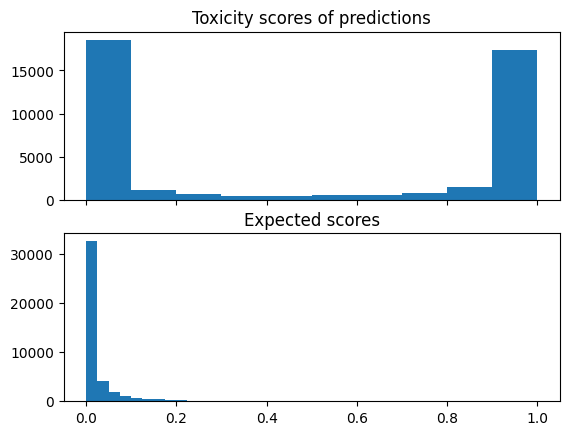

In [73]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, sharex=True)

axs[1].set_title('Expected scores')
axs[1].hist(y_test.tox_score)

axs[0].set_title('Toxicity scores of predictions')
axs[0].hist(scores)

In [71]:
scores = np.array(scores)


def print_stats(arr, start: str = "", round_lim: int = 4):
    mean = round(float(arr.mean()), round_lim)
    std = round(float(arr.std()), round_lim)
    print(start + f"{mean} {std}")


print('Type \t/ mean / std')
print_stats(X_test.tox_score, 'Initial:  ')
print_stats(scores, 'Resulted: ')
print_stats(y_test.tox_score, 'Expected: ')

Type 	/ mean / std
Initial:  0.9665 0.0489
Resulted: 0.4864 0.4607
Expected: 0.0199 0.0384


# Outcomes of the session

We can see that our baseline model reduced toxicity from high to low on almost half of the sentences. Which is proving out hypothesys 1.4 seems to be right. However there is also other half of messages that are still defined as toxic even after curse/high-correlation words removal. For that reason, we should test another solution (for example any architecture analyzed in `ArchitectureAnalysis` notebook). For such reason, we can test hypothesis that deep-learning model with memory cells can reduce toxicity even lower. But for now, we achieved mean toxicity score drop from `0.9665` to `0.4864` (judging by `SkolkovoInstitute/roberta_toxicity_classifier`)

# Credits

Notebook created by Polina Zelenskaya\
Innopolis University DS21-03

Github: [github.com/cutefluffyfox](https://github.com/cutefluffyfox)\
Email: p.zelenskaya@innopolis.university
